## Bayesian Linear Regression test

In [1]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class LinearBayes(object):
    """
    A class that holds parameter prior/posterior and handles 
    the hyper-parameter updates with new data
    
    Note:  variables starting with "v_" indicate Nx1 dimensional 
        column vectors, those starting with "m_" indicate 
        matrices, and those starting with "a_" indicate 
        1xN dimensional arrays.
    
    Args:
        a_m0 (np.array): prior mean vector of size 1xM
        m_S0 (np.ndarray): prior covariance matrix of size MxM
        beta (float): known real-data noise precision
        
    """
    def __init__(self, a_m0, m_S0, beta):
        self.prior = mv_norm(mean=a_m0, cov=m_S0)
        self.v_m0 = a_m0.reshape(a_m0.shape + (1,)) #reshape to column vector
        self.m_S0 = m_S0
        self.beta = beta
        
        self.v_mN = self.v_m0
        self.m_SN = self.m_S0
        self.posterior = self.prior
           
    def get_phi(self, a_x):
        """
        Returns the design matrix of size (NxM) for a feature vector v_x.
        In this case, this function merely adds the phi_0 dummy basis
        that's equal to 1 for all elements.
        
        Args:
            a_x (np.array): input features of size 1xN
        """
        m_phi = np.ones((len(a_x), 2))
        m_phi[:, 1] = a_x
        return m_phi
        
    def set_posterior(self, a_x, a_t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        # Need to convert v_t from an array into a column vector
        # to correctly compute matrix multiplication
        v_t = a_t.reshape(a_t.shape + (1,))

        m_phi = self.get_phi(a_x)
        
        self.m_SN = np.linalg.inv(np.linalg.inv(self.m_S0) + self.beta*m_phi.T.dot(m_phi))
        self.v_mN = self.m_SN.dot(np.linalg.inv(self.m_S0).dot(self.v_m0) + \
                                      self.beta*m_phi.T.dot(v_t))
        
        self.posterior = mv_norm(mean=self.v_mN.flatten(), cov=self.m_SN)

    
    def prediction_limit(self, a_x, stdevs):
        """
        Calculates the limit that's "stdevs" standard deviations
        away from the mean at a given value of x.
        
        Args:
            a_x (np.array): x-axis values of size 1xN
            stdevs (float): Number of standard deviations away from
                the mean to calculate the prediction limit
        
        Returns:
            np.array: the prediction limit "stdevs" standard deviations
                away from the mean corresponding to x-values in "v_x"
        
        """
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append((mean_x+stdevs*np.sqrt(sig_sq_x)).flatten())
        return np.concatenate(predictions)
    
    def generate_data(self, a_x):
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append(normal(mean_x.flatten(), np.sqrt(sig_sq_x)))
        return np.array(predictions)
    
    def make_contour(self, a_x, a_y, real_parms=[], N=0):
        """
        A helper function to generate contour plots of our probability distribution
        """
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
            
        _ = plt.title('Distribution for Weight Parameters using %d datapoint(s)' % N, fontsize=10)
    
    def make_scatter(self, a_x, a_t, real_parms, samples=None, stdevs=None):
        """
        A helper function to plot noisey data, the true function, 
        and optionally a set of lines specified by the nested array of
        weights of size NxM where N is number of lines, M is 2 for 
        this simple model
        """
        plt.scatter(a_x, a_t, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('t')

        plt.plot([-1, 1], real_function(real_parms[0], real_parms[1], 0, np.array([-1., 1.])), 'r')

        _ = plt.title('Real Data from Noisey Linear Function')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], real_function(weight[0], weight[1], 0, np.array([-1., 1.])), 'black')
                _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')
                
        if stdevs:
            a_xrange = np.linspace(-1, 1, 100)
            y_upper = self.prediction_limit(a_xrange, stdevs)
            y_lower = self.prediction_limit(a_xrange, -stdevs)
            plt.plot(a_xrange, y_upper, '+', c='green', linewidth=4.0)
            plt.plot(a_xrange, y_lower, '+', c='green', linewidth=4.0)
            _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')

In [4]:
def real_function(a_0, a_1, noise_sigma, x):
    """
    Evaluates the real function
    """
    N = len(x)
    if noise_sigma==0:
        # Recovers the true function
        return a_0 + a_1*x
    else:
        return a_0 + a_1*x + normal(0, noise_sigma, N)

In [6]:
# Real function parameters
a_0 = -0.3
a_1 = -1.5
noise_sigma = 0.2
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) # Set the seed so we can get reproducible results
x_real = uniform(-1, 1, 1000)
# Evaluate the real function for training example inputs
t_real = real_function(a_0, a_1, noise_sigma, x_real)

In [9]:
t_real.shape

(1000,)

In [10]:
x_real.shape

(1000,)

In [25]:
alpha = 3.0
v_m0 = np.array([0., 0.])
m_S0 = 1/alpha*np.identity(2)

linbayes = LinearBayes(v_m0, m_S0, beta)

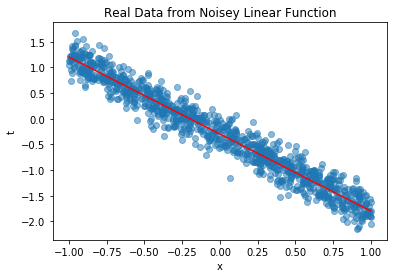

In [26]:
linbayes.make_scatter(x_real, t_real, real_parms = [a_0, a_1])

## Bayesian Regression from PyMC3

In [4]:
import pandas as pd

In [34]:
from sklearn.linear_model import ARDRegression, BayesianRidge

In [38]:
data = pd.read_csv("data/Advertising.csv")

In [15]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

In [45]:
X = data[["TV", "Radio", "Newspaper"]]

In [46]:
y = data[["Sales"]]

In [47]:
data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [48]:
model_data = dict(x=X, y=y)

In [50]:
formula = 'Sales ~ ' + ' + '.join(['%s' % variable for variable in X.columns[:]])
formula

'Sales ~ TV + Radio + Newspaper'

In [51]:
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = data, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, Newspaper, Radio, TV, Intercept]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:08<00:00, 581.97draws/s]
The acceptance probability does not match the target. It is 0.9420934088097324, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9209864482847451, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning

<Figure size 504x504 with 0 Axes>

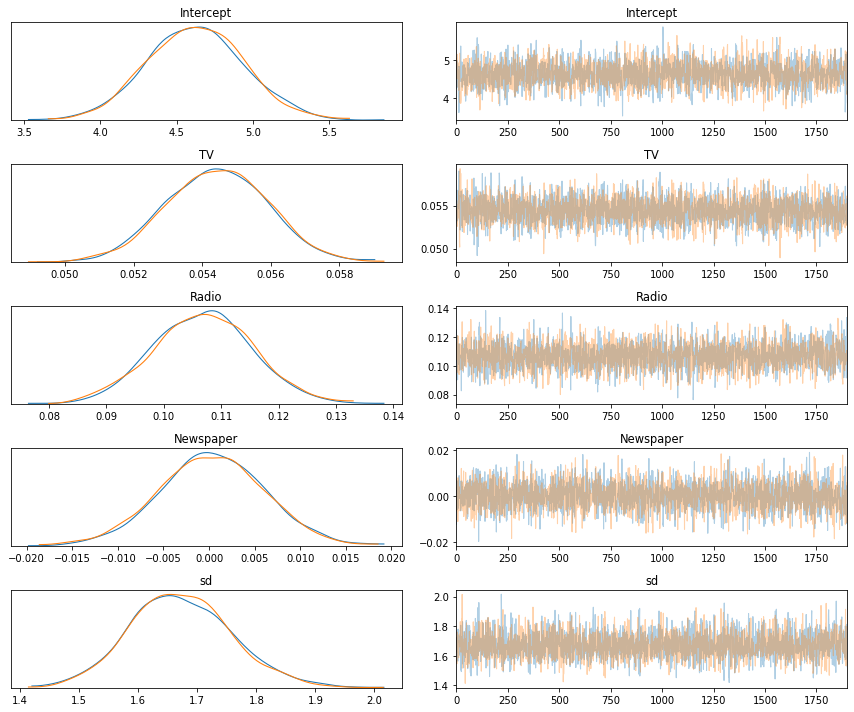

In [52]:
plt.figure(figsize=(7, 7))
pm.traceplot(normal_trace[100:])
plt.tight_layout();

In [42]:
lif = LinearRegression().fit(X, y)

In [43]:
lif.coef_

array([[0.05444578, 0.10700123, 0.00033566]])

In [44]:
X

,TV,Radio,Newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4
...,...,...,...
195,38.2,3.7,13.8
196,94.2,4.9,8.1
197,177.0,9.3,6.4
198,283.6,42.0,66.2


## Bayesian Regression from sklearn

In [38]:
data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [46]:
reg = LinearRegression().fit(X, y)

In [47]:
reg.coef_

array([0.05444578, 0.10700123, 0.00033566])

In [58]:
clf = ARDRegression(compute_score=True).fit(X, y)

In [59]:
clf.coef_

array([0., 0., 0.])

In [60]:
clf1 = BayesianRidge().fit(X, y)

In [61]:
clf1.coef_

array([ 8.66369146e-04, -9.31789255e-05, -1.36832468e-03])

In [23]:
# Boston Housing example
from sklearn.datasets import load_boston
boston = load_boston()

In [60]:
data = pd.DataFrame(boston.data, columns=boston.feature_names)
X = data

In [61]:
y = boston.target

In [30]:
reg = LinearRegression().fit(X, y)

In [31]:
reg.coef_

array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

In [71]:
clf = ARDRegression(compute_score=True).fit(X, y)

In [72]:
clf.coef_

array([-1.09028853e-01,  4.09649677e-02,  0.00000000e+00,  2.67793321e+00,
       -1.74479669e+01,  3.72657759e+00,  0.00000000e+00, -1.43819254e+00,
        2.47443938e-01, -1.07810757e-02, -9.25327481e-01,  0.00000000e+00,
       -5.50727135e-01])

In [148]:
clf1 = BayesianRidge(alpha_2 = 40, lambda_2 = 0.1).fit(X, y)

In [149]:
clf1.coef_

array([-0.10143585,  0.04973548, -0.04381883,  1.89599655, -2.14624324,
        3.67459111, -0.01061991, -1.24529321,  0.28020219, -0.01406109,
       -0.79727095,  0.01003677, -0.56182936])

In [92]:
clf2 = BayesianRidge(alpha_1 = 4000, lambda_2 = 0.001).fit(X, y)

In [93]:
clf2.coef_

array([-1.07718767e-01,  4.65024528e-02,  1.80789788e-02,  2.67776514e+00,
       -1.71783115e+01,  3.81445923e+00,  1.69082191e-04, -1.46689872e+00,
        3.04669462e-01, -1.23812563e-02, -9.46225101e-01,  9.34235661e-03,
       -5.25411626e-01])

In [94]:
clf1 = BayesianRidge(alpha_1 = 40, lambda_2 = 0.01, normalize=True).fit(X, y)
clf1.coef_

array([-1.03639032e-01,  4.34712552e-02,  5.51691745e-03,  2.74508192e+00,
       -1.66511280e+01,  3.86402168e+00, -3.18921856e-04, -1.41497927e+00,
        2.69935438e-01, -1.06129402e-02, -9.35003467e-01,  9.28819343e-03,
       -5.16114066e-01])

In [96]:
clf1.alpha_

0.05170711359820225

In [129]:
type(clf1.coef_)

numpy.ndarray

In [62]:
X['Price'] = y

In [63]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [64]:
from sklearn.linear_model import ARDRegression, BayesianRidge
import pandas as pd
import pymc3 as pm

def bayes_linear_modeling(df, selected_col, target_col, model_option, alpha_1=0.005, lambda_1=0.005, alpha_2=0.005, lambda_2=0.005):
    """
    alpha_init, lambda_init can be set in sklearn==0.22, which can also impact the estimators
    posterior_mean = alpha/lambda in bayesian ridge
    alpha, lambda are shape parameter for Gamma distribution
    
    Output:
    coef
    distribution_plot
    """
#     feature_list = df.columns
#     feature_list = [i for i in feature_list if i != selected_col]
    
    if model_option == "Bayesian Ridge":
        clf = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1, alpha_2=alpha_2, lambda_2=lambda_2, normalize=True).fit(df[selected_col], y)
        return [clf.coef_, ]
    elif model_option == "Bayesian Linear":
        # Using PyMC3
        formula = str(target_col)+' ~ '+' + '.join(['%s' % variable for variable in selected_col])

        with pm.Model() as normal_model:
            family = pm.glm.families.Normal()
            pm.GLM.from_formula(formula, data = df, family = family)
            normal_trace = pm.sample(draws=2000, chains=2, tune=500)
            
            return [np.array([normal_trace[variable] for variable in normal_trace.varnames]),
                    (plt.figure(figsize=(7,7)),traceplot(normal_trace[100:]), plt.tight_layout())]

In [65]:
target_col = "Price"
selected_col = ["CRIM", "ZN", "AGE", "NOX", "DIS", "TAX"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, TAX, DIS, NOX, AGE, ZN, CRIM, Intercept]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 5000/5000 [00:54<00:00, 91.55draws/s]
The acceptance probability does not match the target. It is 0.9107765814463743, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9742667656328244, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:

[array([[ 5.24300469e+01,  4.80822136e+01,  5.08991374e+01, ...,
          5.36473728e+01,  5.03995202e+01,  4.91703543e+01],
        [-2.05368842e-01, -1.48280788e-01, -2.88303258e-02, ...,
         -2.08038167e-01, -2.70697683e-01, -1.78376547e-01],
        [ 1.43080865e-01,  1.61192566e-01,  1.50451184e-01, ...,
          1.34815313e-01,  1.33440846e-01,  1.41745757e-01],
        ...,
        [-1.68533137e-02, -2.06600721e-02, -2.35569478e-02, ...,
         -1.47423814e-02, -1.36415400e-02, -1.57460700e-02],
        [ 1.94496770e+00,  2.04528254e+00,  1.99121392e+00, ...,
          1.99266691e+00,  2.02984154e+00,  1.96756976e+00],
        [ 6.99340598e+00,  7.73134263e+00,  7.32441961e+00, ...,
          7.33506965e+00,  7.61287990e+00,  7.15327117e+00]]),
 (<Figure size 504x504 with 0 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026933999A08>,
        dtype=object),
  None)]

<Figure size 504x504 with 0 Axes>

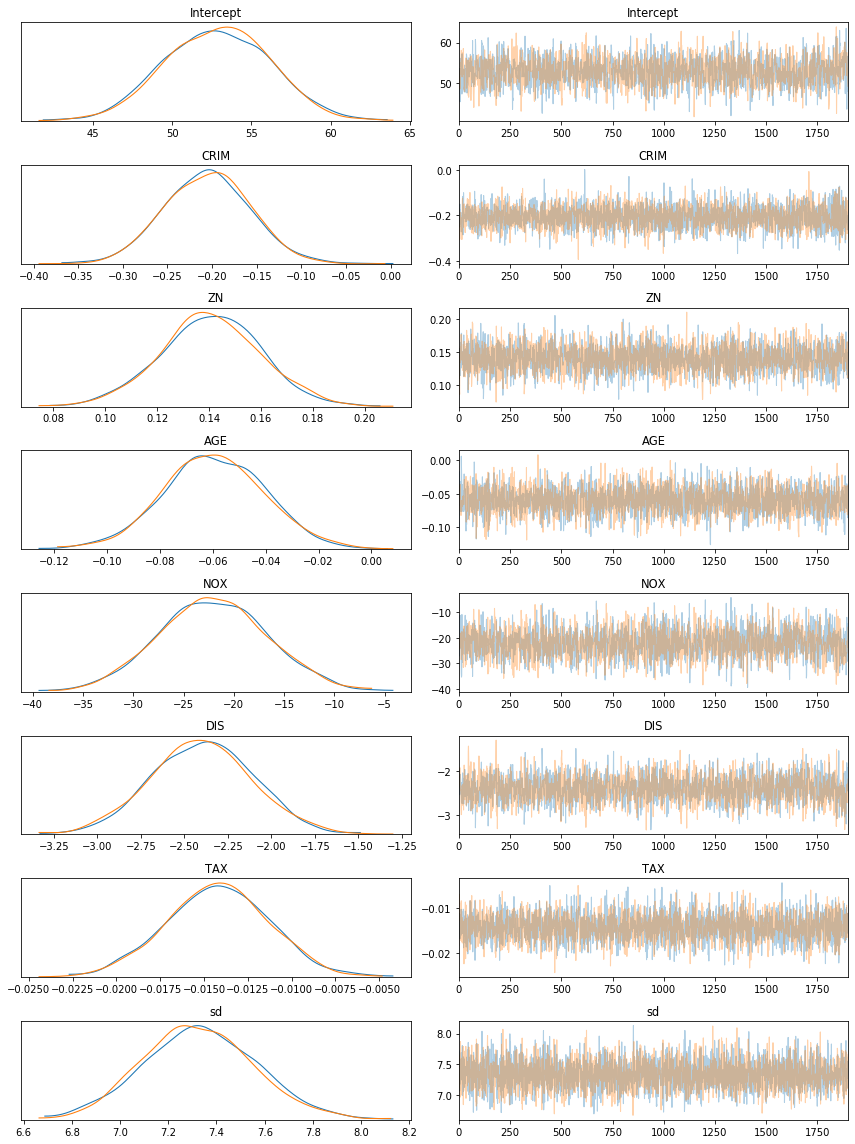

In [66]:
bayes_linear_modeling(df=X, selected_col=selected_col, target_col=target_col, model_option="Bayesian Linear")

C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Yiming.Yu\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning

<Figure size 504x504 with 0 Axes>

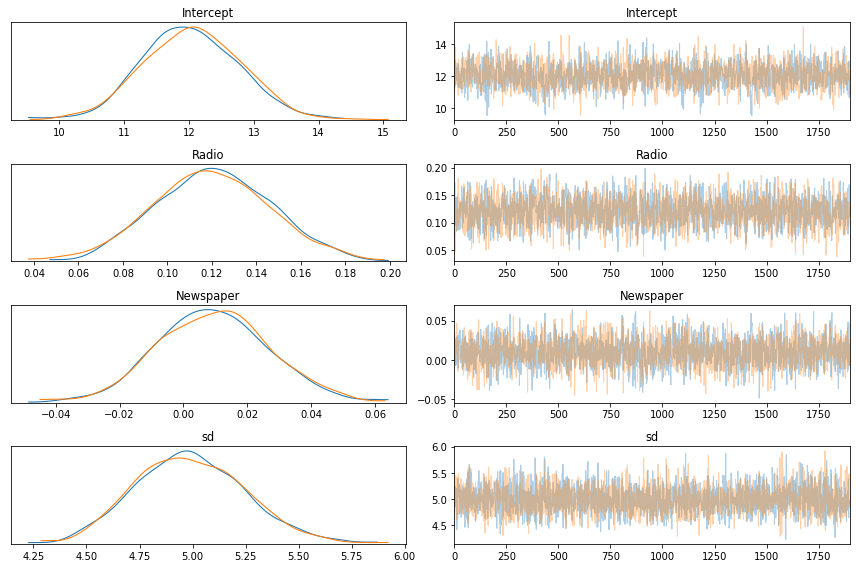

In [36]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace[100:])
plt.tight_layout();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000269377BB9C8>,
      dtype=object)

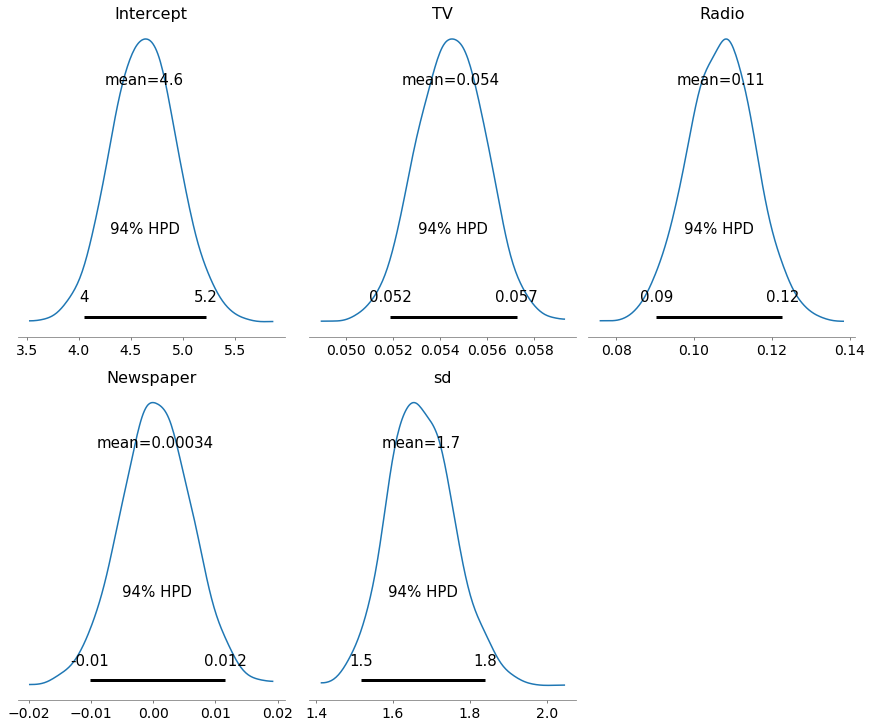

In [71]:
pm.plot_posterior(normal_trace, figsize=(12,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026932121D88>],
      dtype=object)

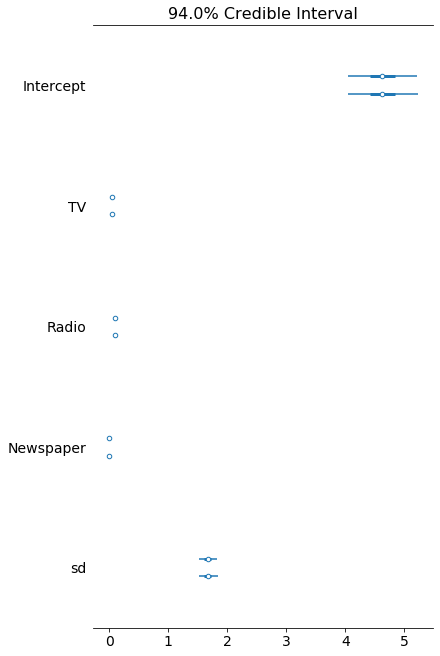

In [70]:
pm.forestplot(normal_trace)